In [1]:
import torch
import copy
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import Backgammon as B
import agent as A
import flipped_agent as FA

In [2]:
class backgammon:
    def __init__(self):
        self.board = B.init_board()
            
    def reset(self):
        self.board = B.init_board()
        self.done = False
        
    def choose_board(self, board):
        self.board = board
        self.done = False
        return np.copy(self.board)
    
    def legal_moves(self, dice, player):
        moves, boards = B.legal_moves(board = self.board, dice = dice, player = player)
        if len(boards) == 0:
            return [], self.board
        return moves, np.vstack(boards)
    
    def swap_player(self):
        self.board = FA.flip_board(board_copy=np.copy(self.board))
    
    # oppents random move
    def make_move(self, dice):
        moves, _ = self.legal_moves(dice, -1)
        if len(moves) == 0:
            return self.step([], -1)
        move = moves[np.random.randint(len(moves))]
        return self.step(move, -1)
    
    def step(self, move, player):
        if len(move) != 0:
            for m in move:
                self.board = B.update_board(board = self.board, move = m, player = player)
        reward = 0
        self.done = False
        if self.iswin():
            reward = player
            self.done = True
        return np.copy(self.board), reward, self.done
        
    def iswin(self):
        return B.game_over(self.board)
        
    def render(self):
        B.pretty_print(self.board)

In [3]:
def reset_graph(seed=43):
    #tf.reset_default_graph()
    #tf.set_random_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
reset_graph()

In [4]:
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H1, H2, H3, D_out = 29, 32, 64, 128, 1

actor = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H2, H3),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H3, D_out),
    torch.nn.Softmax(dim=0),
)
critic = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H2, H3),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H3, D_out),
    torch.nn.Tanh(),
)

In [5]:
def get_action_and_value(actor, boards):
    boards = torch.from_numpy(boards).float()
    possible_actions_probs = actor(boards)
    with torch.no_grad():
        action = int(torch.multinomial(possible_actions_probs.view(1,-1), 1))
    action_value = possible_actions_probs[action]
    return action, action_value

def get_action_value(actor, boards, action):
    boards = torch.from_numpy(boards).float()
    possible_actions_probs = actor(boards)
    action_value = possible_actions_probs[action]
    return action_value

def get_action(actor, boards):
    with torch.no_grad():
        boards = torch.from_numpy(boards).float()
        possible_actions_probs = actor(boards)
        action = torch.multinomial(possible_actions_probs.view(1,-1), 1)
    return int(action)

def get_state_value(nn_model, after_state):
    after_state = torch.from_numpy(after_state).float()
    value = nn_model(after_state)
    return value

def epsilon_greedy(critic, possible_boards, epsilon=.9):
    possible_boards = torch.from_numpy(possible_boards).float()
    values = critic(possible_boards)
    if np.random.random()<epsilon:
        _ , index = values.max(0)
    else:
        index = np.random.randint(0, len(possible_boards))
    return int(index)

In [6]:
import time
rew_plt = []

def playAgainstRandom(num_games = 100, clear = True):
    global rew_plt
    rew = []
    for episode in range(num_games):
        env.reset()
        done = False

        while not done:
            dice = B.roll_dice()
            for i in range(1 + int(dice[0] == dice[1])):
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                if len(possible_moves) == 0:
                    break
                action = get_action(actor, possible_boards)
                after_state, reward, done = env.step(possible_moves[action], player = 1)
                if done:
                    break

            if not done:
                dice = B.roll_dice()
                for i in range(1 + int(dice[0] == dice[1])):
                    next_state, reward, done = env.make_move(dice)
                    if done:
                        break


        rew.append(reward)

    if clear:
        clear_output(True)
    rew_plt.append(np.mean(np.equal(rew,1)))
    rew = []
    plt.plot(rew_plt)
    plt.axhline(0.5, color="gray")
    plt.show()
    print("Win rate:", rew_plt[-1])

EPISODE:  20 Steps: 1
EPISODE:  40 Steps: 1
EPISODE:  60 Steps: 1
EPISODE:  80 Steps: 1
EPISODE:  100 Steps: 1


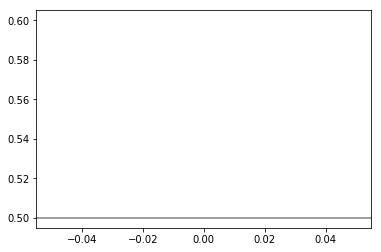

Win rate: 0.6
Time per 100: 40.24075365066528
EPISODE:  100
EPISODE:  120 Steps: 1
EPISODE:  140 Steps: 1
EPISODE:  160 Steps: 1
EPISODE:  180 Steps: 1
EPISODE:  200 Steps: 1


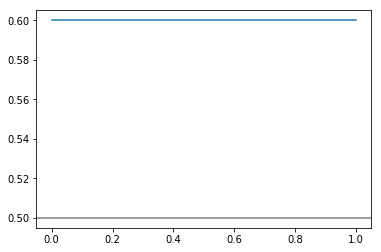

Win rate: 0.6
Time per 100: 35.96316862106323
EPISODE:  200
EPISODE:  220 Steps: 1
EPISODE:  240 Steps: 1
EPISODE:  260 Steps: 1
EPISODE:  280 Steps: 1
EPISODE:  300 Steps: 1


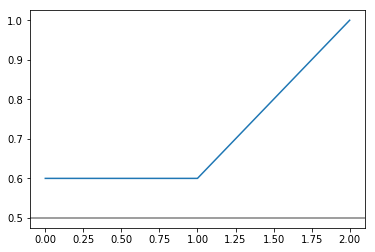

Win rate: 1.0
Time per 100: 27.67476797103882
EPISODE:  300
EPISODE:  320 Steps: 1
EPISODE:  340 Steps: 1
EPISODE:  360 Steps: 1
EPISODE:  380 Steps: 1
EPISODE:  400 Steps: 1


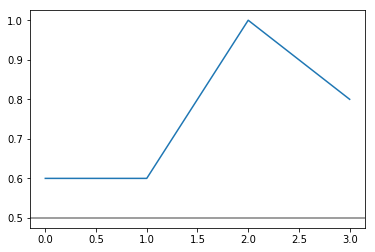

Win rate: 0.8
Time per 100: 30.254036903381348
EPISODE:  400
EPISODE:  420 Steps: 1
EPISODE:  440 Steps: 1
EPISODE:  460 Steps: 1
EPISODE:  480 Steps: 1
EPISODE:  500 Steps: 1


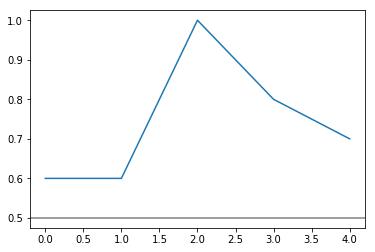

Win rate: 0.7
Time per 100: 42.70491147041321
EPISODE:  500
EPISODE:  520 Steps: 1
EPISODE:  540 Steps: 1
EPISODE:  560 Steps: 1
EPISODE:  580 Steps: 1
EPISODE:  600 Steps: 1


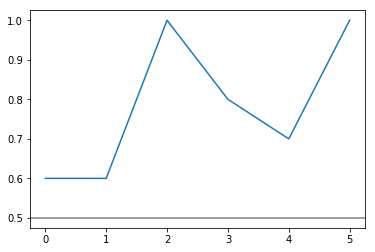

Win rate: 1.0
Time per 100: 52.219547271728516
EPISODE:  600
EPISODE:  620 Steps: 1
EPISODE:  640 Steps: 1
EPISODE:  660 Steps: 1
EPISODE:  680 Steps: 1
EPISODE:  700 Steps: 1


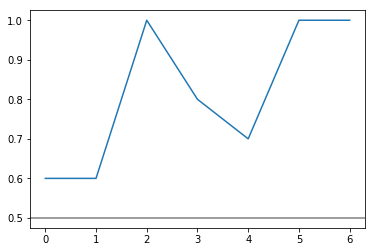

Win rate: 1.0
Time per 100: 56.282092332839966
EPISODE:  700
EPISODE:  720 Steps: 1
EPISODE:  740 Steps: 1
EPISODE:  760 Steps: 1
EPISODE:  780 Steps: 1
EPISODE:  800 Steps: 1


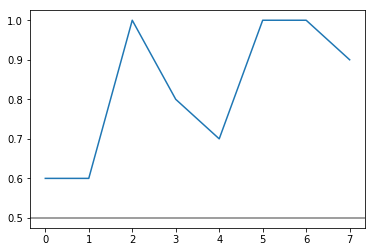

Win rate: 0.9
Time per 100: 50.13300800323486
EPISODE:  800
EPISODE:  820 Steps: 1
EPISODE:  840 Steps: 1
EPISODE:  860 Steps: 1
EPISODE:  880 Steps: 1
EPISODE:  900 Steps: 1


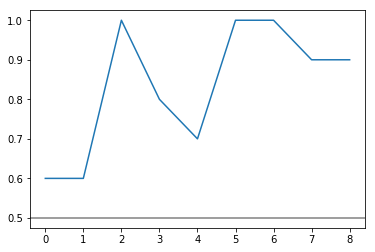

Win rate: 0.9
Time per 100: 60.246524810791016
EPISODE:  900
EPISODE:  920 Steps: 1
EPISODE:  940 Steps: 1
EPISODE:  960 Steps: 1
EPISODE:  980 Steps: 1
EPISODE:  1000 Steps: 1


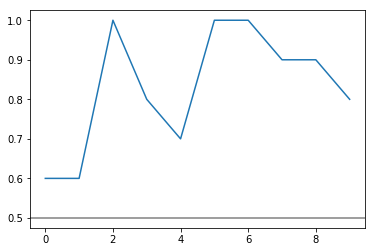

Win rate: 0.8
Time per 100: 57.45351767539978
EPISODE:  1000
EPISODE:  1020 Steps: 1
EPISODE:  1040 Steps: 1
EPISODE:  1060 Steps: 1
EPISODE:  1080 Steps: 1
EPISODE:  1100 Steps: 1


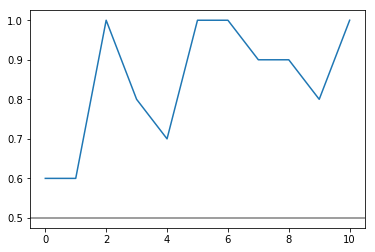

Win rate: 1.0
Time per 100: 82.59501385688782
EPISODE:  1100
EPISODE:  1120 Steps: 1
EPISODE:  1140 Steps: 1
EPISODE:  1160 Steps: 1
EPISODE:  1180 Steps: 1
EPISODE:  1200 Steps: 1


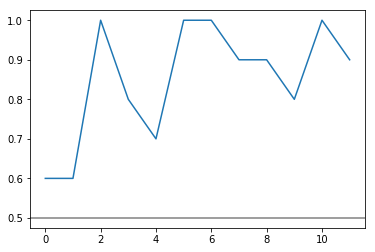

Win rate: 0.9
Time per 100: 88.25293397903442
EPISODE:  1200
EPISODE:  1220 Steps: 1
EPISODE:  1240 Steps: 1
EPISODE:  1260 Steps: 1
EPISODE:  1280 Steps: 1
EPISODE:  1300 Steps: 1


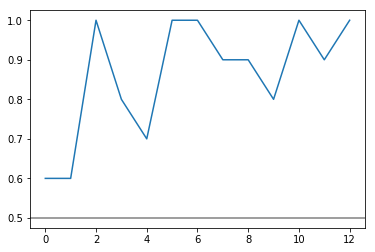

Win rate: 1.0
Time per 100: 66.13531446456909
EPISODE:  1300
EPISODE:  1320 Steps: 1
EPISODE:  1340 Steps: 1
EPISODE:  1360 Steps: 1
EPISODE:  1380 Steps: 1
EPISODE:  1400 Steps: 1


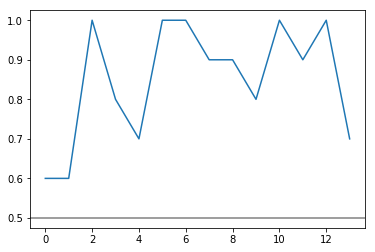

Win rate: 0.7
Time per 100: 36.084200382232666
EPISODE:  1400
EPISODE:  1420 Steps: 1
EPISODE:  1440 Steps: 1
EPISODE:  1460 Steps: 1
EPISODE:  1480 Steps: 1
EPISODE:  1500 Steps: 1


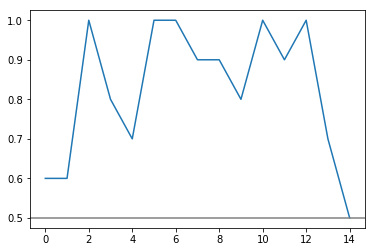

Win rate: 0.5
Time per 100: 30.178994178771973
EPISODE:  1500
EPISODE:  1520 Steps: 1
EPISODE:  1540 Steps: 1
EPISODE:  1560 Steps: 1
EPISODE:  1580 Steps: 1
EPISODE:  1600 Steps: 1


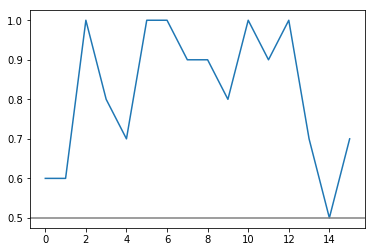

Win rate: 0.7
Time per 100: 26.27459692955017
EPISODE:  1600
EPISODE:  1620 Steps: 1
EPISODE:  1640 Steps: 1
EPISODE:  1660 Steps: 1
EPISODE:  1680 Steps: 1
EPISODE:  1700 Steps: 1


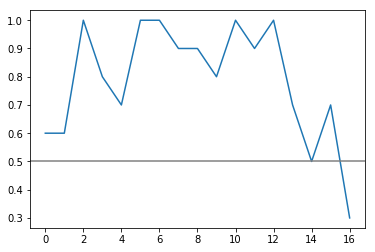

Win rate: 0.3
Time per 100: 21.27819538116455
EPISODE:  1700
EPISODE:  1720 Steps: 1
EPISODE:  1740 Steps: 1
EPISODE:  1760 Steps: 1
EPISODE:  1780 Steps: 1
EPISODE:  1800 Steps: 1


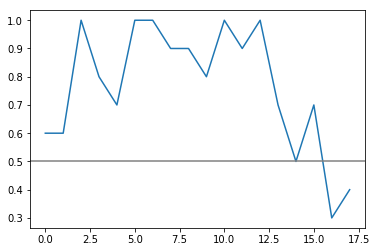

Win rate: 0.4
Time per 100: 18.827252626419067
EPISODE:  1800
EPISODE:  1820 Steps: 1
EPISODE:  1840 Steps: 1
EPISODE:  1860 Steps: 1
EPISODE:  1880 Steps: 1
EPISODE:  1900 Steps: 1


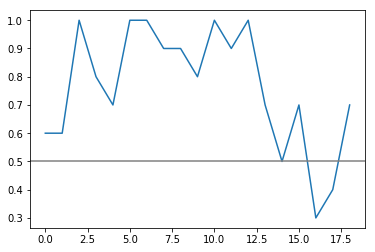

Win rate: 0.7
Time per 100: 20.451362371444702
EPISODE:  1900
EPISODE:  1920 Steps: 1
EPISODE:  1940 Steps: 1
EPISODE:  1960 Steps: 1
EPISODE:  1980 Steps: 1
EPISODE:  2000 Steps: 1


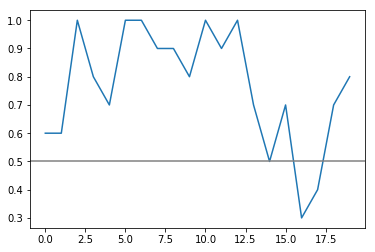

Win rate: 0.8
Time per 100: 22.089614152908325
EPISODE:  2000
EPISODE:  2020 Steps: 1
EPISODE:  2040 Steps: 1
EPISODE:  2060 Steps: 1
EPISODE:  2080 Steps: 1
EPISODE:  2100 Steps: 1


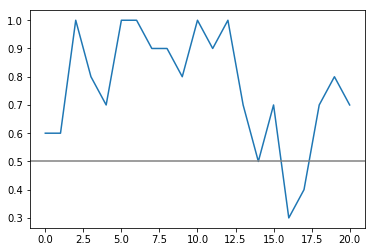

Win rate: 0.7
Time per 100: 40.283058404922485
EPISODE:  2100
EPISODE:  2120 Steps: 1
EPISODE:  2140 Steps: 1
EPISODE:  2160 Steps: 1
EPISODE:  2180 Steps: 1
EPISODE:  2200 Steps: 1


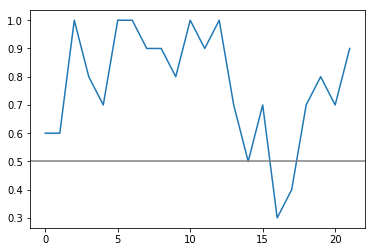

Win rate: 0.9
Time per 100: 44.20437526702881
EPISODE:  2200
EPISODE:  2220 Steps: 1
EPISODE:  2240 Steps: 1
EPISODE:  2260 Steps: 1
EPISODE:  2280 Steps: 1
EPISODE:  2300 Steps: 1


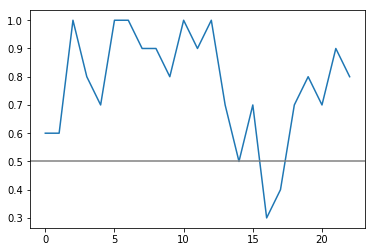

Win rate: 0.8
Time per 100: 47.98290228843689
EPISODE:  2300
EPISODE:  2320 Steps: 1
EPISODE:  2340 Steps: 1
EPISODE:  2360 Steps: 1
EPISODE:  2380 Steps: 1
EPISODE:  2400 Steps: 1


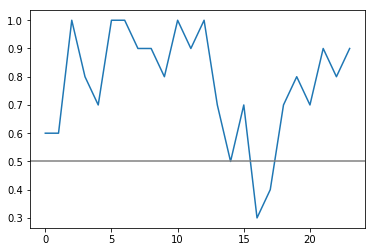

Win rate: 0.9
Time per 100: 45.79894757270813
EPISODE:  2400
EPISODE:  2420 Steps: 1
EPISODE:  2440 Steps: 1
EPISODE:  2460 Steps: 1
EPISODE:  2480 Steps: 1
EPISODE:  2500 Steps: 1


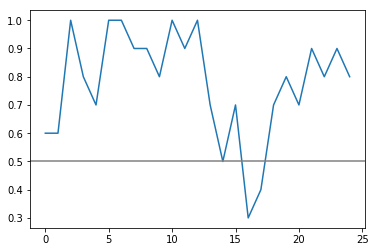

Win rate: 0.8
Time per 100: 46.42821955680847
EPISODE:  2500
EPISODE:  2520 Steps: 1
EPISODE:  2540 Steps: 1
EPISODE:  2560 Steps: 1
EPISODE:  2580 Steps: 1
EPISODE:  2600 Steps: 1


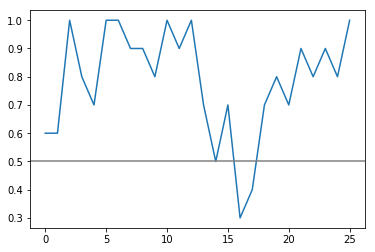

Win rate: 1.0
Time per 100: 44.248332262039185
EPISODE:  2600
EPISODE:  2620 Steps: 1
EPISODE:  2640 Steps: 1
EPISODE:  2660 Steps: 1
EPISODE:  2680 Steps: 1
EPISODE:  2700 Steps: 1


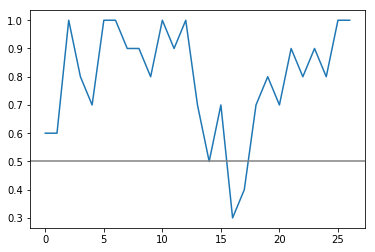

Win rate: 1.0
Time per 100: 51.764522552490234
EPISODE:  2700
EPISODE:  2720 Steps: 1
EPISODE:  2740 Steps: 1
EPISODE:  2760 Steps: 1
EPISODE:  2780 Steps: 1
EPISODE:  2800 Steps: 1


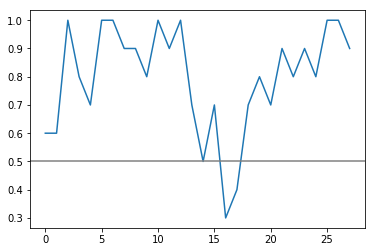

Win rate: 0.9
Time per 100: 48.313350200653076
EPISODE:  2800
EPISODE:  2820 Steps: 1
EPISODE:  2840 Steps: 1
EPISODE:  2860 Steps: 1
EPISODE:  2880 Steps: 1
EPISODE:  2900 Steps: 1


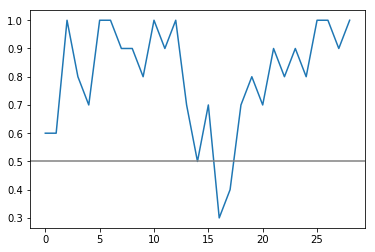

Win rate: 1.0
Time per 100: 45.50988173484802
EPISODE:  2900
EPISODE:  2920 Steps: 1
EPISODE:  2940 Steps: 1
EPISODE:  2960 Steps: 1
EPISODE:  2980 Steps: 1
EPISODE:  3000 Steps: 1


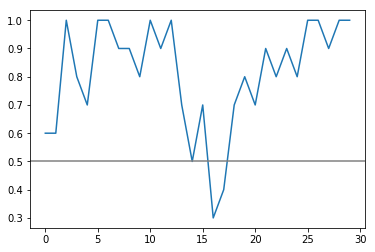

Win rate: 1.0
Time per 100: 51.82140517234802
EPISODE:  3000
EPISODE:  3020 Steps: 1
EPISODE:  3040 Steps: 1
EPISODE:  3060 Steps: 1
EPISODE:  3080 Steps: 1
EPISODE:  3100 Steps: 1


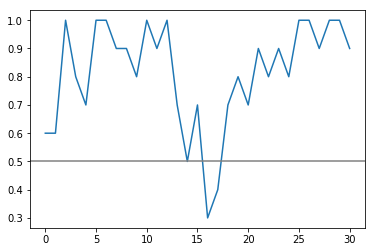

Win rate: 0.9
Time per 100: 49.30847358703613
EPISODE:  3100
EPISODE:  3120 Steps: 1
EPISODE:  3140 Steps: 1
EPISODE:  3160 Steps: 1
EPISODE:  3180 Steps: 1
EPISODE:  3200 Steps: 1


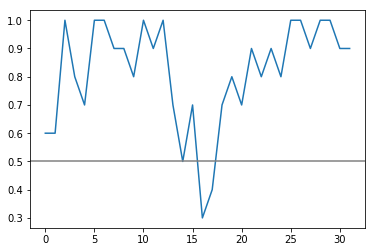

Win rate: 0.9
Time per 100: 47.12381982803345
EPISODE:  3200
EPISODE:  3220 Steps: 1
EPISODE:  3240 Steps: 1
EPISODE:  3260 Steps: 1
EPISODE:  3280 Steps: 1
EPISODE:  3300 Steps: 1


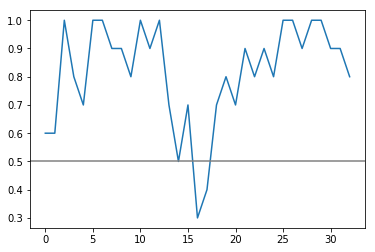

Win rate: 0.8
Time per 100: 43.405874729156494
EPISODE:  3300
EPISODE:  3320 Steps: 1
EPISODE:  3340 Steps: 1
EPISODE:  3360 Steps: 1
EPISODE:  3380 Steps: 1
EPISODE:  3400 Steps: 1


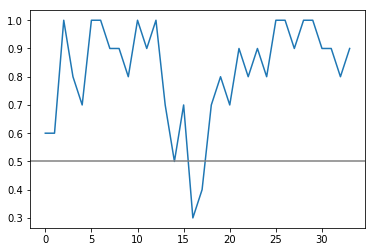

Win rate: 0.9
Time per 100: 41.501625537872314
EPISODE:  3400
EPISODE:  3420 Steps: 1
EPISODE:  3440 Steps: 1
EPISODE:  3460 Steps: 1
EPISODE:  3480 Steps: 1
EPISODE:  3500 Steps: 1


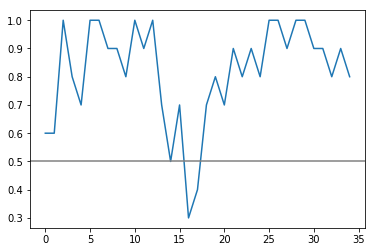

Win rate: 0.8
Time per 100: 43.89064383506775
EPISODE:  3500
EPISODE:  3520 Steps: 1
EPISODE:  3540 Steps: 1
EPISODE:  3560 Steps: 1
EPISODE:  3580 Steps: 1
EPISODE:  3600 Steps: 1


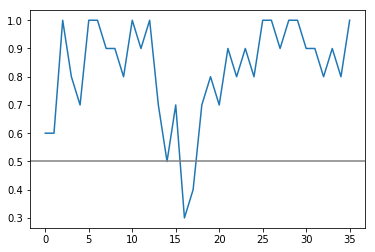

Win rate: 1.0
Time per 100: 39.59232759475708
EPISODE:  3600
EPISODE:  3620 Steps: 1
EPISODE:  3640 Steps: 1
EPISODE:  3660 Steps: 1
EPISODE:  3680 Steps: 1
EPISODE:  3700 Steps: 1


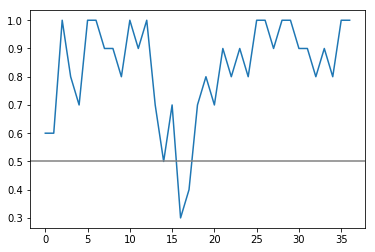

Win rate: 1.0
Time per 100: 42.85836052894592
EPISODE:  3700
EPISODE:  3720 Steps: 1
EPISODE:  3740 Steps: 1
EPISODE:  3760 Steps: 1
EPISODE:  3780 Steps: 1
EPISODE:  3800 Steps: 1


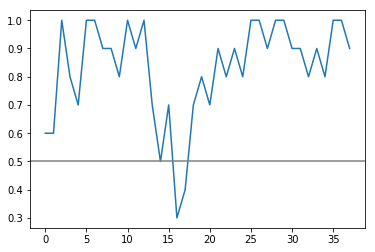

Win rate: 0.9
Time per 100: 48.05367350578308
EPISODE:  3800
EPISODE:  3820 Steps: 1
EPISODE:  3840 Steps: 1
EPISODE:  3860 Steps: 1
EPISODE:  3880 Steps: 1
EPISODE:  3900 Steps: 1


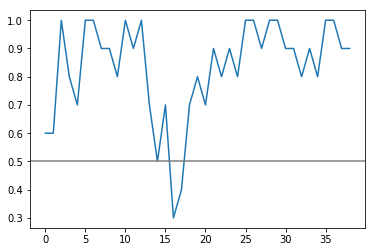

Win rate: 0.9
Time per 100: 48.36162304878235
EPISODE:  3900
EPISODE:  3920 Steps: 1
EPISODE:  3940 Steps: 1
EPISODE:  3960 Steps: 1
EPISODE:  3980 Steps: 1
EPISODE:  4000 Steps: 1


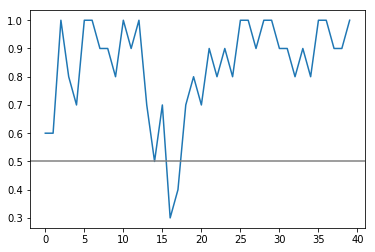

Win rate: 1.0
Time per 100: 45.53892683982849
EPISODE:  4000
EPISODE:  4020 Steps: 1
EPISODE:  4040 Steps: 1
EPISODE:  4060 Steps: 1
EPISODE:  4080 Steps: 1
EPISODE:  4100 Steps: 1


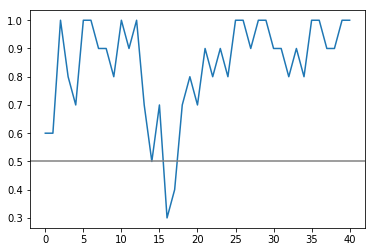

Win rate: 1.0
Time per 100: 40.9290452003479
EPISODE:  4100
EPISODE:  4120 Steps: 1
EPISODE:  4140 Steps: 1
EPISODE:  4160 Steps: 1
EPISODE:  4180 Steps: 1
EPISODE:  4200 Steps: 1


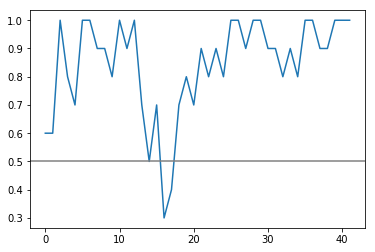

Win rate: 1.0
Time per 100: 45.533607006073
EPISODE:  4200
EPISODE:  4220 Steps: 1
EPISODE:  4240 Steps: 1
EPISODE:  4260 Steps: 1
EPISODE:  4280 Steps: 1
EPISODE:  4300 Steps: 1


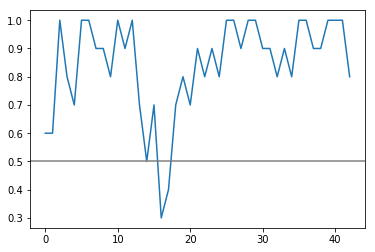

Win rate: 0.8
Time per 100: 50.29541873931885
EPISODE:  4300
EPISODE:  4320 Steps: 1
EPISODE:  4340 Steps: 1
EPISODE:  4360 Steps: 1
EPISODE:  4380 Steps: 1
EPISODE:  4400 Steps: 1


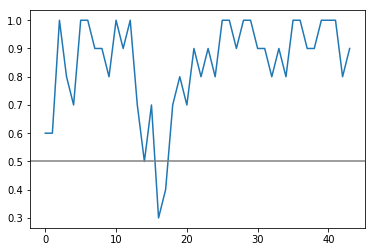

Win rate: 0.9
Time per 100: 48.080148220062256
EPISODE:  4400
EPISODE:  4420 Steps: 1
EPISODE:  4440 Steps: 1
EPISODE:  4460 Steps: 1
EPISODE:  4480 Steps: 1
EPISODE:  4500 Steps: 1


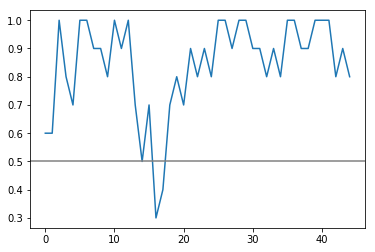

Win rate: 0.8
Time per 100: 45.54795742034912
EPISODE:  4500
EPISODE:  4520 Steps: 1
EPISODE:  4540 Steps: 1
EPISODE:  4560 Steps: 1
EPISODE:  4580 Steps: 1
EPISODE:  4600 Steps: 1


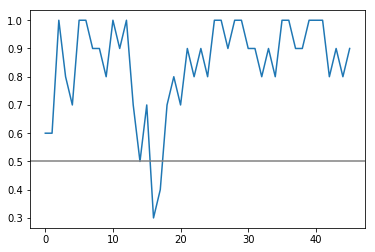

Win rate: 0.9
Time per 100: 44.26721405982971
EPISODE:  4600
EPISODE:  4620 Steps: 1
EPISODE:  4640 Steps: 1
EPISODE:  4660 Steps: 1
EPISODE:  4680 Steps: 1
EPISODE:  4700 Steps: 1


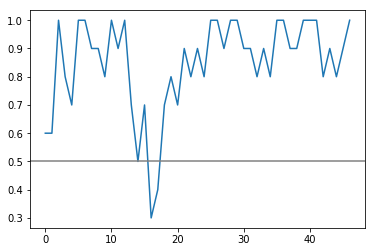

Win rate: 1.0
Time per 100: 46.73683428764343
EPISODE:  4700
EPISODE:  4720 Steps: 1
EPISODE:  4740 Steps: 1
EPISODE:  4760 Steps: 1
EPISODE:  4780 Steps: 1
EPISODE:  4800 Steps: 1


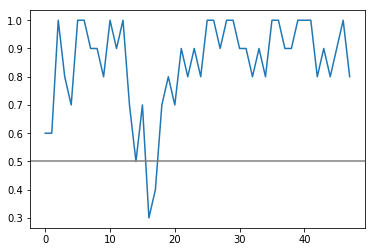

Win rate: 0.8
Time per 100: 42.61839485168457
EPISODE:  4800
EPISODE:  4820 Steps: 1
EPISODE:  4840 Steps: 1
EPISODE:  4860 Steps: 1
EPISODE:  4880 Steps: 1
EPISODE:  4900 Steps: 1


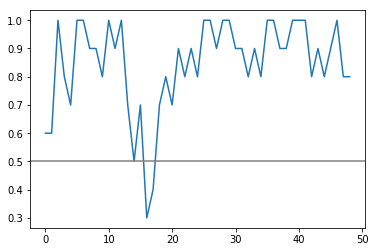

Win rate: 0.8
Time per 100: 47.93829083442688
EPISODE:  4900
EPISODE:  4920 Steps: 1
EPISODE:  4940 Steps: 1
EPISODE:  4960 Steps: 1
EPISODE:  4980 Steps: 1
EPISODE:  5000 Steps: 1


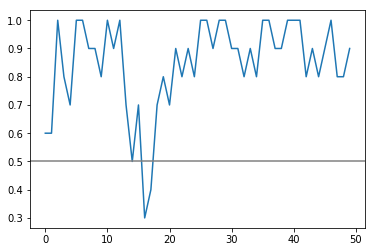

Win rate: 0.9
Time per 100: 45.83609127998352
EPISODE:  5000


In [9]:
gamma = 0.99
actor_alpha = 0.01
critic_alpha = 0.01
actor_lambda = 0.7
critic_lambda = 0.7
forever = 5000

plt_iter = 100

env = backgammon()
tic = time.time()
step = 1

for episode in range(1,forever+1):
    if (episode%20==0):
        print("EPISODE: ", episode, "Steps:", step)

    env.reset()
    done = False
    step = 1
    
    I = 1
    actor_Z = [ [0 for layer in actor.parameters()] for player in range(2) ]
    critic_Z = [ [0 for layer in critic.parameters()] for player in range(2) ]
    value = [[0,0],[0,0]] #value[player][0(old),1(new)]
        
    player = 0
    while not done:
        dice = B.roll_dice()
        for i in range(1 + int(dice[0] == dice[1])):
            possible_moves, possible_boards = env.legal_moves(dice, 1)
            if len(possible_moves) == 0:
                break
            action, pi = get_action_and_value(actor, possible_boards) # Using actor
            pi.clamp(min=1e-8) # so that log does not become nan
            log_pi = torch.log(pi) 
            actor.zero_grad()
            log_pi.backward()
            with torch.no_grad():
                for i, param in enumerate(actor.parameters()):
                    actor_Z[player][i] = actor_lambda * I * actor_Z[player][i] + param.grad
            after_state, reward, done = env.step(possible_moves[action], player = 1)
            if done:
                break
                
        if not done:
            value[player][0] = float(value[player][1]) # old_value
            value[player][1] = get_state_value(critic, after_state)
            critic.zero_grad()
            value[player][1].backward()
            with torch.no_grad():
                for i, param in enumerate(critic.parameters()):
                    critic_Z[player][i] = critic_lambda * critic_Z[player][i] + param.grad
            if (step>2):
                with torch.no_grad():
                    reward = 0 # Reward er 0
                    delta = reward + gamma*value[player][1] - value[player][0]
                    
                    for i, param in enumerate(actor.parameters()):
                        param += actor_alpha * delta * actor_Z[player][i] 
                    for i, param in enumerate(critic.parameters()):
                        param += critic_alpha * delta * critic_Z[player][i]
            
            if player==0:
                I *= gamma
                step += 1
            player = not player
            env.swap_player()
            
    value[player][0] = float(value[player][1])
    value[player][1] = 0
    
    value[not player][0] = float(value[not player][1])
    value[not player][1] = 0
    
    with torch.no_grad():
        delta1 = reward + gamma*value[player][1] - value[player][0]
        delta2 = -reward + gamma*value[not player][1] - value[not player][0]
        
        for i, param in enumerate(actor.parameters()):
            param += actor_alpha * delta1 * actor_Z[player][i]
            param += actor_alpha * delta2 * actor_Z[not player][i] 
        for i, param in enumerate(critic.parameters()):
            param += critic_alpha * delta1 * critic_Z[player][i]
            param += critic_alpha * delta2 * critic_Z[not player][i]
            
    if episode%plt_iter == 0:
        toc = time.time()
        playAgainstRandom(num_games = 10, clear = False)
        print("Time per {}: {}".format(plt_iter, toc-tic))
        print("EPISODE: ", episode)
        tic = time.time()
        

